In [1]:
from __future__ import print_function

import os

import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [3]:
train_set = torchvision.datasets.CIFAR100('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR100('./datasets', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, 
                                          shuffle=False, num_workers=2)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./datasets/cifar-100-python.tar.gz to ./datasets
Files already downloaded and verified


In [4]:
classes = ('cattle',
'dinosaur',
'apple',
'boy',
'aquarium_fish',
'telephone',
'train',
'cup',
'cloud',
'elephant',
'keyboard',
'willow_tree',
'sunflower',
'castle',
'sea',
'bicycle',
'wolf',
'squirrel',
'shrew',
'pine_tree',
'rose',
'television',
'table',
'possum',
'oak_tree',
'leopard',
'maple_tree',
'rabbit',
'chimpanzee',
'clock',
'streetcar',
'cockroach',
'snake',
'lobster',
'mountain',
'palm_tree',
'skyscraper',
'tractor',
'shark',
'butterfly',
'bottle',
'bee',
'chair',
'woman',
'hamster',
'otter',
'seal',
'lion',
'mushroom',
'girl',
'sweet_pepper',
'forest',
'crocodile',
'orange',
'tulip',
'mouse',
'camel',
'caterpillar',
'man',
'skunk',
'kangaroo',
'raccoon',
'snail',
'rocket',
'whale',
'worm',
'turtle',
'beaver',
'plate',
'wardrobe',
'road',
'fox',
'flatfish',
'tiger',
'ray',
'dolphin',
'poppy',
'porcupine',
'lamp',
'crab',
'motorcycle',
'spider',
'tank',
'orchid',
'lizard',
'beetle',
'bridge',
'baby',
'lawn_mower',
'house',
'bus',
'couch',
'bowl',
'pear',
'bed',
'plain',
'trout',
'bear',
'pickup_truck',
'can')


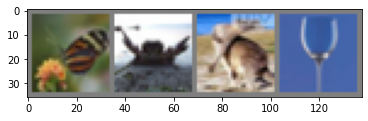

In [5]:
import matplotlib.pyplot as plt


def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [7]:
class SEAttention(nn.Module):

    def __init__(self, channel=512,reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [8]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
        self.se = SEAttention(out_channels * self.expansion)
            
    def forward(self, x):
        out = self.features(x)
        out += self.shortcut(x)
        
        out = self.se(out)
        
        out = torch.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))

            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [10]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

net = ResNet18().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)

    torch.backends.cudnn.benchmark = True

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (se): SEAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_

In [11]:
lr = 1e-1
momentum = 0.9
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.1, patience=3, verbose=True)

In [12]:
def train(epoch):
    print('\nEpoch: %d' % (epoch))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.6f |  Acc: %.3f%% (%d/%d)' %
                  (epoch + 1, batch_idx + 1, train_loss, 100.*correct/total, correct, total))
    return train_loss

In [13]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/res18.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [14]:
def plot_loss(train_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
train_losses = []


for epoch in range(start_epoch, 50):
    loss = train(epoch)
    train_losses.append(loss)
    print('Total loss: %.6f' % loss)
    start_epoch = epoch
    scheduler.step(loss, epoch=epoch)


Epoch: 0
[1,   100] loss: 469.617777 |  Acc: 1.375% (22/1600)
[1,   200] loss: 921.700501 |  Acc: 1.688% (54/3200)
[1,   300] loss: 1366.699351 |  Acc: 2.250% (108/4800)
[1,   400] loss: 1809.150607 |  Acc: 2.484% (159/6400)
[1,   500] loss: 2243.265340 |  Acc: 2.612% (209/8000)
[1,   600] loss: 2676.990853 |  Acc: 2.719% (261/9600)
[1,   700] loss: 3104.231479 |  Acc: 2.929% (328/11200)
[1,   800] loss: 3530.541118 |  Acc: 3.078% (394/12800)
[1,   900] loss: 3953.777750 |  Acc: 3.160% (455/14400)
[1,  1000] loss: 4371.633345 |  Acc: 3.350% (536/16000)
[1,  1100] loss: 4788.391685 |  Acc: 3.528% (621/17600)
[1,  1200] loss: 5201.133273 |  Acc: 3.677% (706/19200)
[1,  1300] loss: 5614.755998 |  Acc: 3.870% (805/20800)
[1,  1400] loss: 6024.472254 |  Acc: 3.973% (890/22400)
[1,  1500] loss: 6434.483323 |  Acc: 3.987% (957/24000)
[1,  1600] loss: 6841.580933 |  Acc: 4.211% (1078/25600)
[1,  1700] loss: 7243.896022 |  Acc: 4.386% (1193/27200)
[1,  1800] loss: 7643.059158 |  Acc: 4.601% (1

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:920: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[2,   100] loss: 377.210600 |  Acc: 10.000% (160/1600)
[2,   200] loss: 756.735651 |  Acc: 10.344% (331/3200)
[2,   300] loss: 1133.911677 |  Acc: 10.333% (496/4800)
[2,   400] loss: 1509.111589 |  Acc: 10.625% (680/6400)
[2,   500] loss: 1876.956685 |  Acc: 11.025% (882/8000)
[2,   600] loss: 2249.586493 |  Acc: 10.927% (1049/9600)
[2,   700] loss: 2618.505822 |  Acc: 11.071% (1240/11200)
[2,   800] loss: 2992.516064 |  Acc: 11.086% (1419/12800)
[2,   900] loss: 3361.463436 |  Acc: 11.125% (1602/14400)
[2,  1000] loss: 3731.662163 |  Acc: 11.250% (1800/16000)
[2,  1100] loss: 4097.114103 |  Acc: 11.432% (2012/17600)
[2,  1200] loss: 4464.095148 |  Acc: 11.599% (2227/19200)
[2,  1300] loss: 4832.955791 |  Acc: 11.639% (2421/20800)
[2,  1400] loss: 5195.052693 |  Acc: 11.772% (2637/22400)
[2,  1500] loss: 5561.979355 |  Acc: 11.825% (2838/24000)
[2,  1600] loss: 5926.542810 |  Acc: 11.906% (3048/25600)
[2,  1700] loss: 6293.612593 |  Acc: 11.945% (3249/27200)
[2,  1800] loss: 6660.08367

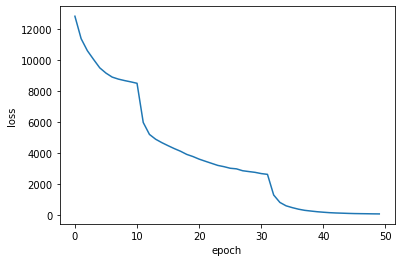

In [15]:
plot_loss(train_losses)

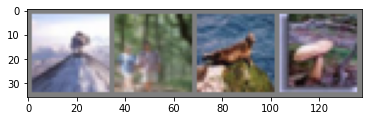

GroundTruth:   girl lobster flatfish forest
Predicted:  plate lobster flatfish forest
Accuracy of the network on the 10000 test images: 63 %


In [16]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [17]:
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [18]:
for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cattle : 95 %
Accuracy of dinosaur : 77 %
Accuracy of apple : 50 %
Accuracy of   boy : 68 %
Accuracy of aquarium_fish : 56 %
Accuracy of telephone : 70 %
Accuracy of train : 69 %
Accuracy of   cup : 41 %
Accuracy of cloud : 74 %
Accuracy of elephant : 82 %
Accuracy of keyboard : 62 %
Accuracy of willow_tree : 42 %
Accuracy of sunflower : 57 %
Accuracy of castle : 57 %
Accuracy of   sea : 56 %
Accuracy of bicycle : 60 %
Accuracy of  wolf : 64 %
Accuracy of squirrel : 73 %
Accuracy of shrew : 53 %
Accuracy of pine_tree : 77 %
Accuracy of  rose : 87 %
Accuracy of television : 80 %
Accuracy of table : 63 %
Accuracy of possum : 80 %
Accuracy of oak_tree : 84 %
Accuracy of leopard : 62 %
Accuracy of maple_tree : 54 %
Accuracy of rabbit : 31 %
Accuracy of chimpanzee : 75 %
Accuracy of clock : 66 %
Accuracy of streetcar : 70 %
Accuracy of cockroach : 60 %
Accuracy of snake : 48 %
Accuracy of lobster : 57 %
Accuracy of mountain : 79 %
Accuracy of palm_tree : 29 %
Accuracy of skyscra